In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
torch.set_default_device("cuda")

In [3]:
image_size = 64
batch_size = 1024
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
train_ds = ImageFolder("./data/", transform=tt.Compose([tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor(),
                                                        tt.Normalize(*stats)]))
train_dl = DataLoader(train_ds, batch_size, shuffle=True, generator=torch.Generator(device="cuda"))

In [46]:
latent_size = 128
# This will remain fixed to save samples
fixed_latent = torch.randn((1, latent_size, 1, 1))

In [32]:
generator = nn.Sequential(
    # in : latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [33]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [42]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()
    m = real_images.shape[0]
    real_preds = discriminator(real_images)
    real_targets = torch.ones((m, 1))
    real_loss = F.binary_cross_entropy(real_preds, real_targets)

    latent = torch.randn((m, latent_size, 1, 1))
    fake_images = generator(latent)
    fake_preds = discriminator(fake_images)
    fake_targets = torch.zeros((m, 1))
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item()    

In [43]:
def train_generator(opt_g):
    opt_g.zero_grad()
    latent = torch.randn((batch_size, latent_size, 1, 1))
    fake_images = generator(latent)
    preds = discriminator(fake_images)
    fake_targets = torch.ones((batch_size, 1))
    loss = F.binary_cross_entropy(preds, fake_targets)
    loss.backward()
    opt_g.step()
    return loss.item()

In [58]:
def denorm_img(img):
    return img*stats[1][0] + stats[0][0]

In [60]:
def save_sample(idx):
    image = generator(fixed_latent)
    save_image(denorm_img(image), f"./generated/generated_img_{idx}.png")

In [56]:
def fit(epochs, lr, idx=0):
    torch.cuda.empty_cache()
    losses_d = []
    losses_g = []

    # Create_optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr, betas=(0.5, 0.999))
    # Training Loop
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            loss_d = train_discriminator(real_images.cuda(), opt_d)
            loss_g = train_generator(opt_g)
        losses_d.append(loss_d)
        losses_g.append(loss_g)
        print("Epochs [{}/{}], loss_d: {:.4f}, loss_g: {:.4f}".format(epoch+1, epochs, loss_d, loss_g))
        save_sample(idx)
        idx += 1
    return losses_d, losses_g

In [132]:
history = fit(50, 0.0002, 50)

  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [1/50], loss_d: 0.5866, loss_g: 4.4237


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [2/50], loss_d: 0.6642, loss_g: 3.4737


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [3/50], loss_d: 0.8348, loss_g: 4.7859


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [4/50], loss_d: 1.4485, loss_g: 8.3061


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [5/50], loss_d: 0.5753, loss_g: 5.0975


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [6/50], loss_d: 0.4282, loss_g: 3.9868


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [7/50], loss_d: 0.9618, loss_g: 4.3825


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [8/50], loss_d: 0.4914, loss_g: 4.8548


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [9/50], loss_d: 0.4651, loss_g: 3.3675


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [10/50], loss_d: 1.5619, loss_g: 8.8007


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [11/50], loss_d: 0.3758, loss_g: 3.3834


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [12/50], loss_d: 0.4230, loss_g: 4.6587


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [13/50], loss_d: 1.2503, loss_g: 3.3846


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [14/50], loss_d: 0.4872, loss_g: 3.2484


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [15/50], loss_d: 1.8425, loss_g: 3.9412


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [16/50], loss_d: 0.2875, loss_g: 3.7006


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [17/50], loss_d: 0.5401, loss_g: 3.9965


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [18/50], loss_d: 0.1324, loss_g: 2.9761


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [19/50], loss_d: 0.4628, loss_g: 3.7909


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [20/50], loss_d: 1.2939, loss_g: 6.1929


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [21/50], loss_d: 0.4360, loss_g: 3.2504


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [22/50], loss_d: 0.2705, loss_g: 3.4932


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [23/50], loss_d: 0.8184, loss_g: 1.9473


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [24/50], loss_d: 0.7086, loss_g: 5.4781


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [25/50], loss_d: 0.4484, loss_g: 4.5539


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [26/50], loss_d: 0.2731, loss_g: 4.1878


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [27/50], loss_d: 0.7267, loss_g: 0.8575


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [28/50], loss_d: 2.9805, loss_g: 5.2856


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [29/50], loss_d: 0.4280, loss_g: 3.8707


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [30/50], loss_d: 0.3762, loss_g: 2.2921


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [31/50], loss_d: 0.6796, loss_g: 6.1780


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [32/50], loss_d: 0.4333, loss_g: 5.7706


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [33/50], loss_d: 0.3317, loss_g: 4.2675


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [34/50], loss_d: 0.4174, loss_g: 4.1108


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [35/50], loss_d: 1.6243, loss_g: 1.7037


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [36/50], loss_d: 0.4497, loss_g: 5.4069


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [37/50], loss_d: 4.8427, loss_g: 7.1888


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [38/50], loss_d: 0.3015, loss_g: 3.8170


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [39/50], loss_d: 0.1369, loss_g: 3.5643


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [40/50], loss_d: 1.6361, loss_g: 4.9378


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [41/50], loss_d: 0.6243, loss_g: 6.7733


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [42/50], loss_d: 0.1077, loss_g: 4.2375


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [43/50], loss_d: 0.1325, loss_g: 3.0800


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [44/50], loss_d: 0.4725, loss_g: 7.4714


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [45/50], loss_d: 0.7065, loss_g: 5.1003


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [46/50], loss_d: 0.3617, loss_g: 3.3199


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [47/50], loss_d: 1.3247, loss_g: 9.3032


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [48/50], loss_d: 0.5900, loss_g: 6.6138


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [49/50], loss_d: 1.1392, loss_g: 8.0990


  0%|          | 0/16 [00:00<?, ?it/s]

Epochs [50/50], loss_d: 0.6604, loss_g: 3.3748


In [137]:
# Generating Images
def generate_images(file_path):
    latent_tensor = torch.randn((64, latent_size, 1, 1))
    image = generator(latent_tensor)
    save_image(denorm_img(image), file_path)
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    fig.suptitle("Generating Cats with Generative Adversarial Networks")
    for i, ax in enumerate(axes.flatten()):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(denorm_img(image[i]).cpu().detach().permute(1, 2, 0))
    fig.savefig("./catty_fig.png", dpi=200)

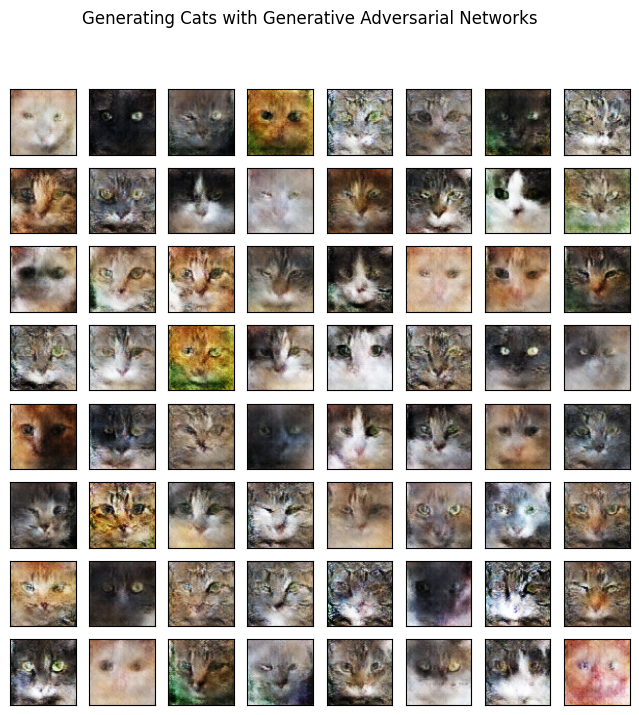

In [138]:
generate_images("./catty.png")